# Time Bar Coverage Ratio

Short `bar_size`, like `1s`, will have many blank bars, causing time bars not consective. While larger `bar_size` such as `10s`, has much fewer blank bars and longer consective bars.

In [1]:
import gc
import os
from operator import itemgetter
from typing import Dict, List, Tuple

import dask.bag as db
import numpy as np
import pandas as pd
import seaborn as sns
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
from scipy import stats

## Read Trade Data

In [2]:
# Trades are sorted by trade_id already(except BitMEX, which is sorted by timestamp)
PER_TRADE_DATA_DIR = '/data/merged_csv'

In [3]:
BTC_PAIRS = [
    ('Binance', 'Spot', 'BTC_USDT'),
    ('Binance', 'Swap', 'BTC_USDT'),
    ('BitMEX', 'Swap', 'BTC_USD'),
    ('Huobi', 'Spot', 'BTC_USDT'),
    ('Huobi', 'Swap', 'BTC_USD'),
    ('OKEx', 'Spot', 'BTC_USDT'),
    ('OKEx', 'Swap', 'BTC_USDT'),
    ('OKEx', 'Swap', 'BTC_USD'),
]

ETH_PAIRS = [
    ('Binance', 'Spot', 'ETH_USDT'),
    ('Binance', 'Swap', 'ETH_USDT'),
    ('BitMEX', 'Swap', 'ETH_USD'),
    ('Huobi', 'Spot', 'ETH_USDT'),
    ('Huobi', 'Swap', 'ETH_USD'),
    ('OKEx', 'Spot', 'ETH_USDT'),
    ('OKEx', 'Swap', 'ETH_USDT'),
    ('OKEx', 'Swap', 'ETH_USD'),
]

In [4]:
def get_csv_file(exchange: str, market_type: str, pair: str)->str:
    assert market_type == 'Spot' or market_type == 'Swap'
    return os.path.join(PER_TRADE_DATA_DIR, f'{exchange}.{market_type}.{pair}.csv')

In [5]:
get_csv_file(*BTC_PAIRS[0])

'/data/merged_csv/Binance.Spot.BTC_USDT.csv'

In [6]:
get_csv_file(*ETH_PAIRS[-1])

'/data/merged_csv/OKEx.Swap.ETH_USD.csv'

In [7]:
def read_csv(trade_csv_file: str)->pd.DataFrame:
    df = pd.read_csv(trade_csv_file, engine='c',
                     dtype={'exchange': 'category', 'marketType': 'category', 'pair': 'category',
                            'timestamp': 'int64', 'price': 'float32',
                            'quantity': 'float32', 'side': 'bool', 'trade_id': 'string'})
    return df

In [8]:
get_csv_file(*ETH_PAIRS[-1])

'/data/merged_csv/OKEx.Swap.ETH_USD.csv'

In [9]:
read_csv(get_csv_file(*ETH_PAIRS[-1])).head()

,exchange,marketType,pair,timestamp,price,quantity,side,trade_id
0,OKEx,Swap,ETH_USD,1588291218207,206.179993,3.880105,True,14122344
1,OKEx,Swap,ETH_USD,1588291218207,206.179993,2.134058,True,14122345
2,OKEx,Swap,ETH_USD,1588291218207,206.179993,2.425066,True,14122346
3,OKEx,Swap,ETH_USD,1588291218207,206.149994,2.279893,True,14122348
4,OKEx,Swap,ETH_USD,1588291218207,206.149994,1.261218,True,14122349


## Build Time Bars

In [10]:
def build_time_bars(input_csv_file: str, bar_size: np.int64)->pd.DataFrame:
    df = read_csv(input_csv_file)
    df['quantity_quote'] = df['quantity'] * df['price']
    df['count'] = 1
    df['bar_index'] = df['timestamp'] // bar_size

    bars_df = df.groupby('bar_index').agg({
            'timestamp': ['first', 'last'],
            'quantity': 'sum',
            'quantity_quote': 'sum',
            'count': 'sum',
        }
    )
    
    column_names_map = {
        'timestamp_first': 'timestamp',
        'timestamp_last': 'timestamp_end',
        'quantity_sum': 'volume',
        'quantity_quote_sum': 'volume_quote',
        'count_sum': 'count'
    }
    # see https://stackoverflow.com/a/14508355/381712
    new_columns_names = [column_names_map['_'.join(col).strip()] for col in bars_df.columns.values] 
    bars_df.columns = new_columns_names

    bars_df['timestamp'] = bars_df['timestamp'] // bar_size * bar_size
    bars_df['timestamp_end'] = bars_df['timestamp'] + bar_size

    exchange, market_type, pair = itemgetter('exchange', 'marketType', 'pair')(df.iloc[0])
    bars_df['exchange'] = exchange
    bars_df['market_type'] = market_type
    bars_df['pair'] = pair
    bars_df['bar_size'] = bar_size
    # sort columns
    bars_df = bars_df[['exchange', 'market_type', 'pair', 'bar_size'] + new_columns_names]

    del df
    gc.collect()
    return bars_df

In [11]:
btc_binance_time_bars = build_time_bars(get_csv_file(*BTC_PAIRS[0]), 4000)

In [12]:
btc_binance_time_bars.head()

,exchange,market_type,pair,bar_size,timestamp,timestamp_end,volume,volume_quote,count
bar_index,,,,,,,,,
397072800,Binance,Spot,BTC_USDT,4000,1588291200000,1588291204000,7.111611,61300.203125,48
397072801,Binance,Spot,BTC_USDT,4000,1588291204000,1588291208000,19.118351,164750.281250,69
397072802,Binance,Spot,BTC_USDT,4000,1588291208000,1588291212000,5.166795,44535.218750,51
397072803,Binance,Spot,BTC_USDT,4000,1588291212000,1588291216000,0.708751,6107.354492,31
397072804,Binance,Spot,BTC_USDT,4000,1588291216000,1588291220000,3.827234,32982.312500,33


In [13]:
btc_binance_time_bars[['volume', 'volume_quote', 'count']].describe([0.5, 0.95])

,volume,volume_quote,count
count,1.082209e+06,1.082209e+06,1.082209e+06
mean,3.273351e+00,3.042649e+04,3.072685e+01
std,1.023471e+01,9.525752e+04,4.525321e+01
min,1.000000e-06,9.412941e-03,1.000000e+00
50%,1.093772e+00,1.019756e+04,2.000000e+01
95%,1.218909e+01,1.132124e+05,8.700000e+01
max,1.556475e+03,1.502407e+07,4.551000e+03


In [14]:
btc_okex_time_bars = build_time_bars(get_csv_file(*BTC_PAIRS[-1]), 4000)

In [15]:
btc_okex_time_bars[['volume', 'volume_quote', 'count']].describe([0.5, 0.95])

,volume,volume_quote,count
count,748375.000000,7.483750e+05,748375.000000
mean,3.784974,3.513456e+04,16.352283
std,11.384358,1.058779e+05,37.282393
min,0.009954,9.999999e+01,1.000000
50%,0.846184,7.900000e+03,6.000000
95%,14.574554,1.352000e+05,60.000000
max,668.302124,6.410500e+06,1508.000000


In [16]:
eth_binance_time_bars = build_time_bars(get_csv_file(*ETH_PAIRS[0]), 8000)

In [17]:
eth_binance_time_bars[['volume', 'volume_quote', 'count']].describe([0.5, 0.95])

,volume,volume_quote,count
count,539621.000000,5.396210e+05,539621.000000
mean,62.771679,1.351490e+04,16.736133
std,186.997116,4.007170e+04,26.438532
min,0.000010,2.074500e-03,1.000000
50%,18.103371,3.945371e+03,10.000000
95%,240.877304,5.169015e+04,52.000000
max,12628.714844,2.373013e+06,1210.000000


In [18]:
eth_okex_time_bars = build_time_bars(get_csv_file(*ETH_PAIRS[-1]), 8000)

In [19]:
eth_okex_time_bars[['volume', 'volume_quote', 'count']].describe([0.5, 0.95])

,volume,volume_quote,count
count,381352.000000,3.813520e+05,381352.000000
mean,60.396667,1.305245e+04,11.378674
std,167.574127,3.651237e+04,23.238726
min,0.040027,9.999999e+00,1.000000
50%,14.163804,3.050000e+03,5.000000
95%,250.191640,5.393450e+04,39.000000
max,12871.413086,2.994430e+06,1516.000000


## Coverage Ratio of Different Time Bar Sizes

In [20]:
def calc_segments(time_bars:pd.DataFrame)->List[Tuple[int, int]]:
    segments = []

    current_begin = time_bars.index[0]
    current_end = time_bars.index[0]+1

    for index in time_bars.index:
        if index == current_end:
            current_end += 1
        elif index > current_end:
            if current_end > (current_begin+1):  # at least two consecutive bars
                segments.append((current_begin, current_end))
            current_begin = index
            current_end = index+1
    return segments

In [21]:
# calc_segments(time_bars)

In [22]:
def calc_stats(csv_file: str, bar_size: int)->pd.Series:
    time_bars = build_time_bars(csv_file, bar_size)
    segments = calc_segments(time_bars)

    num_bars = 0
    volume_total = 0
    volume_usd_total = 0
    ticks_total = 0;
    for seg in segments:
        for index in range(seg[0], seg[1]):
            num_bars += 1
            row = time_bars.loc[index]
            volume_total += row['volume']
            volume_usd_total += row['volume_quote']
            ticks_total += row['count']

    exchange, market_type, pair, bar_size = itemgetter('exchange', 'market_type', 'pair', 'bar_size')(time_bars.iloc[0])
    coverage = {
        'exchange': exchange, 'market_type': market_type, 'pair': pair, 'bar_size': bar_size, 
        'time': num_bars/time_bars.shape[0], 
        'volume': volume_total/time_bars['volume'].sum(), 
        'volume_usd': volume_usd_total/time_bars['volume_quote'].sum(),
        'ticks': ticks_total/time_bars['count'].sum()
    }
    

    del time_bars
    gc.collect()
    return pd.Series(coverage, index =['exchange', 'market_type', 'pair', 'bar_size', 'time', 
                                      'volume', 'volume_usd', 'ticks'])

In [23]:
calc_stats(get_csv_file(*ETH_PAIRS[-1]), 10000)

exchange           OKEx
market_type        Swap
pair            ETH_USD
bar_size          10000
time           0.924388
volume         0.975244
volume_usd     0.974724
ticks          0.968317
dtype: object

In [24]:
def calc_stats_parallel(exchange_market_pairs: List[Tuple[str, str, str]], bar_sizes: List[int])->pd.DataFrame:
    csv_files = [get_csv_file(*exchange_market_pair) for exchange_market_pair in exchange_market_pairs]
    tasks = [(csv_file, bar_size) for bar_size in bar_sizes for csv_file in csv_files]
    with ProgressBar():
        series_arr = db.from_sequence(tasks).map(lambda t: calc_stats(t[0], t[1])).compute()
    stats_df = pd.DataFrame(series_arr)
    stats_df['label'] = stats_df['exchange'] + '_' + stats_df['market_type'] + '_' + stats_df['pair']
    stats_df['label'] = stats_df['label'].astype('category')
    return stats_df

In [25]:
btc_stats_df = calc_stats_parallel(BTC_PAIRS, np.arange(1, 11) * 1000)

[########################################] | 100% Completed | 24min 44.7s


In [26]:
btc_stats_df.head()

,exchange,market_type,pair,bar_size,time,volume,volume_usd,ticks,label
0,Binance,Spot,BTC_USDT,1000,0.981843,0.996029,0.996002,0.993483,Binance_Spot_BTC_USDT
1,Binance,Swap,BTC_USDT,1000,0.964748,0.992216,0.992147,0.988766,Binance_Swap_BTC_USDT
2,BitMEX,Swap,BTC_USD,1000,0.870245,0.964348,0.964152,0.960178,BitMEX_Swap_BTC_USD
3,Huobi,Spot,BTC_USDT,1000,0.886927,0.963656,0.963556,0.944840,Huobi_Spot_BTC_USDT
4,Huobi,Swap,BTC_USD,1000,0.757191,0.887810,0.887188,0.883911,Huobi_Swap_BTC_USD


In [27]:
def plot(stats_df: pd.DataFrame)->None:
    f, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 10))
    target_columns = ['volume', 'volume_usd', 'ticks', 'time']
    for i in range(4):
        sns.pointplot(x='bar_size', y=target_columns[i], hue='label', data=stats_df, ax=axes[i//2, i%2])

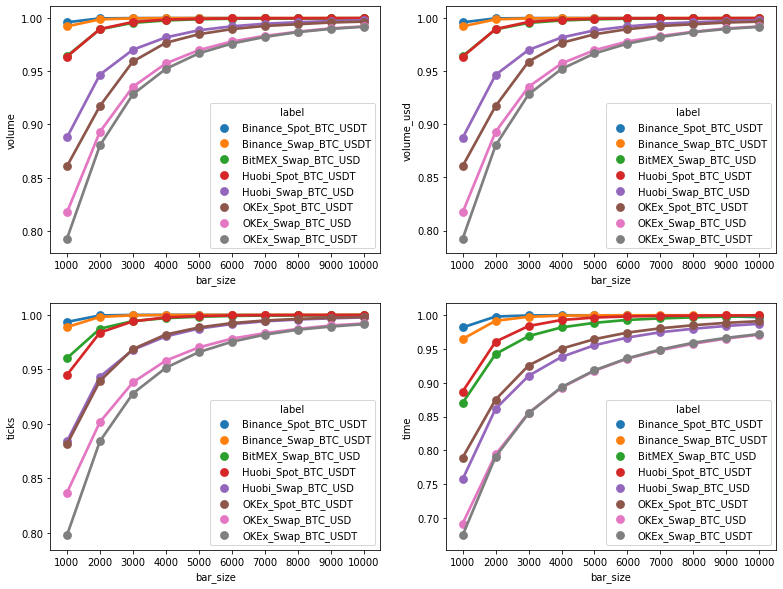

In [28]:
plot(btc_stats_df)

**Conclusion: From each diagram above, we can see when `bar_size>=4s` consecutive bars cover 95% trades.** 

And we can see that Binance, BitMEX have significantly more consecutive bars than Huobi and OKEx, which means Binance and BitMEX have much more high frequency trades thus they have better liqudility.

In [29]:
eth_stats_df = calc_stats_parallel(ETH_PAIRS, np.arange(1, 11) * 1000)

[########################################] | 100% Completed | 15min 10.8s


In [30]:
eth_stats_df.head()

,exchange,market_type,pair,bar_size,time,volume,volume_usd,ticks,label
0,Binance,Spot,ETH_USDT,1000,0.841801,0.949700,0.949212,0.915394,Binance_Spot_ETH_USDT
1,Binance,Swap,ETH_USDT,1000,0.871446,0.946896,0.946661,0.912408,Binance_Swap_ETH_USDT
2,BitMEX,Swap,ETH_USD,1000,0.543205,0.705752,0.704542,0.678168,BitMEX_Swap_ETH_USD
3,Huobi,Spot,ETH_USDT,1000,0.783724,0.915128,0.914121,0.874920,Huobi_Spot_ETH_USDT
4,Huobi,Swap,ETH_USD,1000,0.646621,0.779785,0.776406,0.783536,Huobi_Swap_ETH_USD


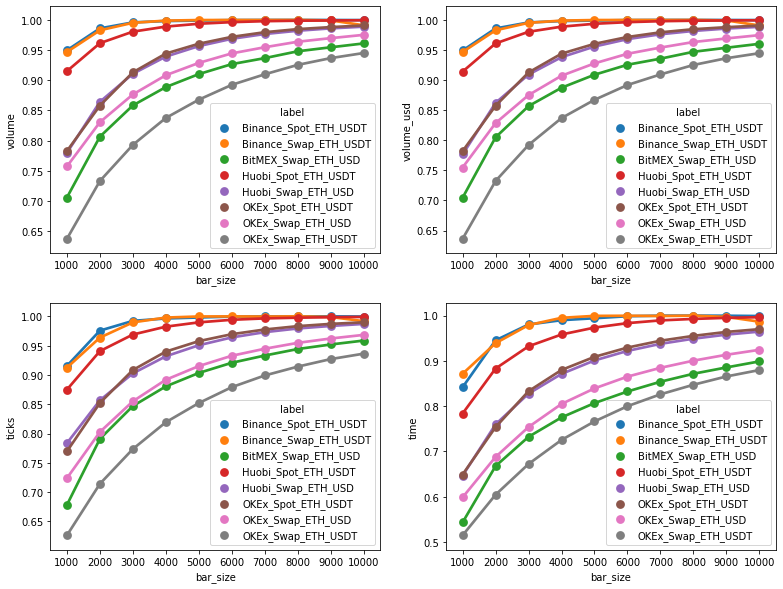

In [31]:
plot(eth_stats_df)

**Conclusion: From each diagram above, we can see when `bar_size>=8s` consecutive bars cover 95% trades.** 

And we can also see that Binance, BitMEX have significantly more consecutive bars than Huobi and OKEx, which means Binance and BitMEX have much more high frequency trades thus they have better liqudility.